<a href="https://colab.research.google.com/github/GOWSALYAR7397/-shopping-mod3-link/blob/main/advance_time_series_forecasting_with_attention_based_lstm_myproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ============================================================
# Advanced Time Series Forecasting with Attention-Based LSTMs
# Google Colab - Section 1: Setup & Imports
# ============================================================

!pip -q install yfinance prophet tqdm seaborn

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import yfinance as yf
from prophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

np.random.seed(42)
tf.random.set_seed(42)

[*********************100%***********************]  1 of 1 completed

Data shape: (2515, 2)


Price,ds,y
Ticker,,^VIX
0,2015-12-03,18.110001
1,2015-12-04,14.810000
2,2015-12-07,15.840000
3,2015-12-08,17.600000
4,2015-12-09,19.610001


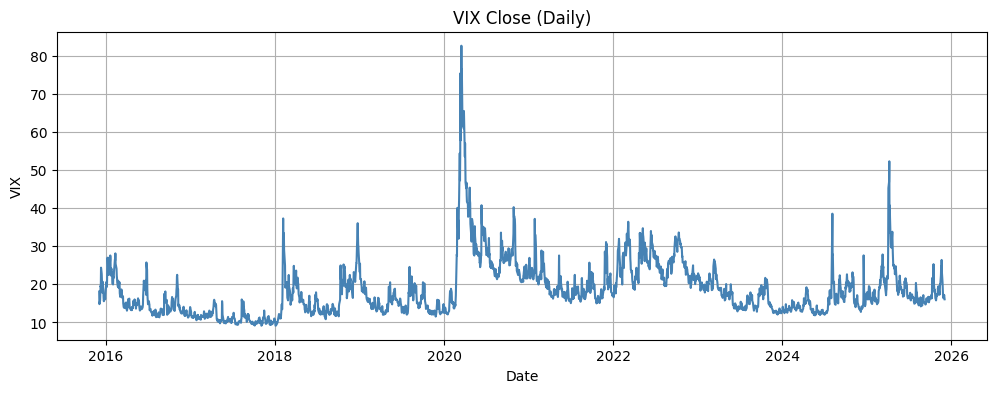

In [3]:
# ============================================================
# Section 2: Data Loading (VIX daily) & Overview
# ============================================================

symbol = "^VIX"
df = yf.download(symbol, period="10y", interval="1d")  # daily frequency
df = df[['Close']].dropna()
df.reset_index(inplace=True)
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values('ds')
print("Data shape:", df.shape)
display(df.head())

plt.figure(figsize=(12,4))
plt.plot(df['ds'], df['y'], color='steelblue')
plt.title("VIX Close (Daily)")
plt.xlabel("Date")
plt.ylabel("VIX")
plt.grid(True)
plt.show()

In [4]:
# ============================================================
# Section 3: Stationarity Check (ADF) & Differencing
# ============================================================

def adf_summary(x):
    result = adfuller(x, autolag='AIC')
    return {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Used Lag': result[2],
        'N Obs': result[3],
        'Critical Values': result[4]
    }

adf_raw = adf_summary(df['y'].values)
print("ADF (raw):", adf_raw)

use_diff = adf_raw['p-value'] > 0.05
print("Use differencing for modeling inputs:", use_diff)

if use_diff:
    df['y_diff'] = df['y'].diff()
    df_diff = df.dropna().copy()
else:
    df_diff = df.copy()

ADF (raw): {'ADF Statistic': np.float64(-5.316599827526929), 'p-value': np.float64(5.0583691946097455e-06), 'Used Lag': 9, 'N Obs': 2505, 'Critical Values': {'1%': np.float64(-3.4329631791044304), '5%': np.float64(-2.8626944896608433), '10%': np.float64(-2.5673845793841457)}}
Use differencing for modeling inputs: False


In [5]:
# ============================================================
# Section 4: Train/Validation/Test Split
# ============================================================

def time_split(data, train_ratio=0.7, val_ratio=0.15):
    n = len(data)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    train = data.iloc[:train_end]
    val = data.iloc[train_end:val_end]
    test = data.iloc[val_end:]
    return train, val, test

target_col = 'y' if not use_diff else 'y_diff'
train_df, val_df, test_df = time_split(df_diff[['ds', target_col]], 0.7, 0.15)
print("Split sizes:", len(train_df), len(val_df), len(test_df))

Split sizes: 1760 377 378


In [6]:
# ============================================================
# Section 5: Scaling & Sequence Construction
# ============================================================

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_df[[target_col]])

train_df['scaled'] = scaler.transform(train_df[[target_col]])
val_df['scaled']   = scaler.transform(val_df[[target_col]])
test_df['scaled']  = scaler.transform(test_df[[target_col]])

L = 60   # input window
H = 10   # forecast horizon

def make_sequences(series, input_len=60, horizon=10):
    X, Y = [], []
    for i in range(len(series) - input_len - horizon + 1):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+horizon])
    return np.array(X), np.array(Y)

X_train, Y_train = make_sequences(train_df['scaled'].values, L, H)
X_val,   Y_val   = make_sequences(val_df['scaled'].values, L, H)
X_test,  Y_test  = make_sequences(test_df['scaled'].values, L, H)

print("Train sequences:", X_train.shape, Y_train.shape)
print("Val sequences:", X_val.shape, Y_val.shape)
print("Test sequences:", X_test.shape, Y_test.shape)

X_train = X_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

Train sequences: (1691, 60) (1691, 10)
Val sequences: (308, 60) (308, 10)
Test sequences: (309, 60) (309, 10)


In [7]:
# ============================================================
# Section 6: Vanilla Seq2Seq LSTM (Baseline) & Training
# ============================================================

def build_vanilla_seq2seq_lstm(input_len=60, horizon=10, units=64, dropout=0.2):
    encoder_inputs = layers.Input(shape=(input_len, 1))
    encoder_lstm = layers.LSTM(units, return_sequences=False, return_state=True, dropout=dropout)
    encoder_out, state_h, state_c = encoder_lstm(encoder_inputs)

    repeat = layers.RepeatVector(horizon)(encoder_out)
    decoder_lstm = layers.LSTM(units, return_sequences=True, dropout=dropout)
    decoder_out = decoder_lstm(repeat, initial_state=[state_h, state_c])

    outputs = layers.TimeDistributed(layers.Dense(1))(decoder_out)
    model = models.Model(encoder_inputs, outputs)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='mae')
    return model

vanilla_model = build_vanilla_seq2seq_lstm(L, H, units=64, dropout=0.2)
vanilla_model.summary()

es  = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history_vanilla = vanilla_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=64,
    callbacks=[es, rlr],
    verbose=1
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 64),      │     16,896 │ input_layer_2[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 10, 64)    │          0 │ lstm_3[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 10, 64)    │     33,024 │ repeat_vector_1[… │
│                     │                   │            │ lstm_3[0][1],     │
│                     │                   │            │ lstm_3[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 10, 1)     │         65 │ lstm_4[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0757 - val_loss: 0.0213 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0513 - val_loss: 0.0200 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0523 - val_loss: 0.0195 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0524 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0512 - val_loss: 0.0195 - learning_rate: 0.0010
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0516 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0537 - val_loss: 0.0189 - learning_rate: 0.0010
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0514 - val_loss: 0.0191 - learning_rate: 0.0010
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0514 - val_loss: 0.0191 - learning_rate: 0.0010
Epoch 10/1

In [10]:
# ============================================================
# Section 7: Attention Seq2Seq LSTM (Bahdanau) & Training
# ============================================================

class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V  = layers.Dense(1)

    def call(self, encoder_outputs, hidden_state):
        # encoder_outputs: (batch, time, units)
        # hidden_state: (batch, units)
        hidden_with_time_axis = tf.expand_dims(hidden_state, 1)
        score = self.V(tf.nn.tanh(self.W1(encoder_outputs) + self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = tf.reduce_sum(attention_weights * encoder_outputs, axis=1)
        return context_vector, attention_weights

def build_attention_seq2seq_lstm(input_len=60, horizon=10, units=64, dropout=0.2):
    encoder_inputs = layers.Input(shape=(input_len, 1))
    encoder_lstm = layers.LSTM(units, return_sequences=True, return_state=True, dropout=dropout)
    encoder_seq, state_h, state_c = encoder_lstm(encoder_inputs)

    attention = BahdanauAttention(units)

    # Decoder: use RepeatVector + TimeDistributed to keep it symbolic
    # We feed the context vector at each horizon step
    context_vector, _ = attention(encoder_seq, state_h)
    repeat_context = layers.RepeatVector(horizon)(context_vector)
    decoder_lstm = layers.LSTM(units, return_sequences=True, dropout=dropout)
    decoder_out = decoder_lstm(repeat_context, initial_state=[state_h, state_c])
    outputs = layers.TimeDistributed(layers.Dense(1))(decoder_out)

    model = models.Model(encoder_inputs, outputs)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='mae')
    return model

attn_model = build_attention_seq2seq_lstm(L, H, units=64, dropout=0.2)
attn_model.summary()

es  = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history_attn = attn_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=64,
    callbacks=[es, rlr],
    verbose=1
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 60, 64),  │     16,896 │ input_layer_5[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention… │ [(None, 64),      │      8,385 │ lstm_7[0][0],     │
│ (BahdanauAttention) │ (None, 60, 1)]    │            │ lstm_7[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 10, 64)    │          0 │ bahdanau_attenti… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 10, 64)    │     33,024 │ repeat_vector_2[… │
│                     │                   │            │ lstm_7[0][1],     │
│                     │                   │            │ lstm_7[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 10, 1)     │         65 │ lstm_8[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,370 (228.01 KB)

 Trainable params: 58,370 (228.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0818 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0557 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0512 - val_loss: 0.0200 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0514 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0504 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0491 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0488 - val_loss: 0.0190 - learning_rate: 0.0010
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0455 - val_loss: 0.0202 - learning_rate: 0.0010
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0511 - val_loss: 0.0195 - learning_rate: 0.0010
Epoch 10/1

In [13]:
# ============================================================
# Section 8: Attention Weights Export & Extraction
# ============================================================

# Reuse the BahdanauAttention layer we defined earlier

class AttentionSeq2SeqExport(tf.keras.Model):
    def __init__(self, units, horizon):
        super().__init__()
        self.units = units
        self.horizon = horizon
        # Encoder
        self.encoder_lstm = layers.LSTM(units, return_sequences=True, return_state=True)
        # Attention
        self.attention = BahdanauAttention(units)
        # Decoder
        self.decoder_lstm = layers.LSTM(units, return_state=True)
        self.fc = layers.Dense(1)

    def call(self, inputs):
        # Encode
        encoder_seq, state_h, state_c = self.encoder_lstm(inputs)
        decoder_state_h, decoder_state_c = state_h, state_c

        outputs, alphas = [], []
        for _ in range(self.horizon):
            # Attention over encoder outputs
            context_vector, alpha = self.attention(encoder_seq, decoder_state_h)
            context_vector_exp = tf.expand_dims(context_vector, 1)
            # One‑step decode
            out, decoder_state_h, decoder_state_c = self.decoder_lstm(
                context_vector_exp, initial_state=[decoder_state_h, decoder_state_c]
            )
            step_out = self.fc(out)
            outputs.append(step_out)
            alphas.append(alpha)

        # Stack outputs and alphas
        outputs = tf.stack(outputs, axis=1)   # (batch, H, 1)
        alphas  = tf.stack(alphas, axis=1)    # (batch, H, L, 1)
        return outputs, alphas

# Build export model (same units/horizon as training)
attn_export = AttentionSeq2SeqExport(units=64, horizon=H)

# Example run on test batch to get predictions + attention weights
preds_attn, alphas = attn_export(X_test[:32])  # eager execution, no KerasTensor error
print("Preds shape:", preds_attn.shape)   # (batch, H, 1)
print("Alphas shape:", alphas.shape)      # (batch, H, L, 1)


Preds shape: (32, 10, 1)
Alphas shape: (32, 10, 60, 1)


In [15]:
# ============================================================
# Section 9: Inverse Scaling, Reconstruction & Metrics (Fixed)
# ============================================================

def inverse_scale_preds(pred_scaled, scaler):
    """Inverse transform predictions (3D: batch,horizon,1)."""
    b, h, c = pred_scaled.shape
    flat = pred_scaled.reshape(-1, 1)
    inv = scaler.inverse_transform(flat).reshape(b, h, c)
    return inv

def inverse_scale_truth(y_scaled, scaler):
    """Inverse transform ground truth (2D: batch,horizon)."""
    b, h = y_scaled.shape
    flat = y_scaled.reshape(-1, 1)
    inv = scaler.inverse_transform(flat).reshape(b, h, 1)
    return inv

# --- Inverse scaling ---
Y_test_inv = inverse_scale_truth(Y_test, scaler)

pred_attn_scaled    = attn_model.predict(X_test, verbose=0)
pred_vanilla_scaled = vanilla_model.predict(X_test, verbose=0)

pred_attn_inv    = inverse_scale_preds(pred_attn_scaled, scaler)
pred_vanilla_inv = inverse_scale_preds(pred_vanilla_scaled, scaler)

# --- If differencing was applied, reconstruct forecasts ---
if use_diff:
    orig_test_segment = df.iloc[len(df) - len(test_df) - (L+H-1) : ]
    base_series = orig_test_segment['y'].values
    last_levels = []
    for i in range(len(base_series) - L - H + 1):
        last_levels.append(base_series[i+L-1])
    last_levels = np.array(last_levels)[..., np.newaxis]

    pred_attn_inv    = reconstruct_from_diff(last_levels, pred_attn_inv)
    pred_vanilla_inv = reconstruct_from_diff(last_levels, pred_vanilla_inv)
    Y_test_inv       = reconstruct_from_diff(last_levels, Y_test_inv)

# --- Metrics computation ---
def metrics_over_horizon(y_true, y_pred, H):
    maes, rmses, mapes = [], [], []
    for t in range(H):
        yt = y_true[:, t, 0]
        yp = y_pred[:, t, 0]
        mae  = mean_absolute_error(yt, yp)
        rmse = np.sqrt(mean_squared_error(yt, yp))
        mape = np.mean(np.abs((yt - yp) / (yt + 1e-8))) * 100
        maes.append(mae); rmses.append(rmse); mapes.append(mape)
    return np.array(maes), np.array(rmses), np.array(mapes)

mae_attn, rmse_attn, mape_attn = metrics_over_horizon(Y_test_inv, pred_attn_inv, H)
mae_van,  rmse_van,  mape_van  = metrics_over_horizon(Y_test_inv, pred_vanilla_inv, H)

print("Attention-LSTM -> MAE(mean):", mae_attn.mean(),
      "RMSE(mean):", rmse_attn.mean(),
      "MAPE(mean%):", mape_attn.mean())

print("Vanilla-LSTM  -> MAE(mean):", mae_van.mean(),
      "RMSE(mean):", rmse_van.mean(),
      "MAPE(mean%):", mape_van.mean())

Attention-LSTM -> MAE(mean): 2.6119493314749214 RMSE(mean): 4.555493801343543 MAPE(mean%): 11.930695025630687
Vanilla-LSTM  -> MAE(mean): 2.4793287703134483 RMSE(mean): 4.411538590124578 MAPE(mean%): 11.301647739588498


Prophet -> MAE: 13.789659083591395 RMSE: 15.103329909073539 MAPE(%): 73.94110899246948


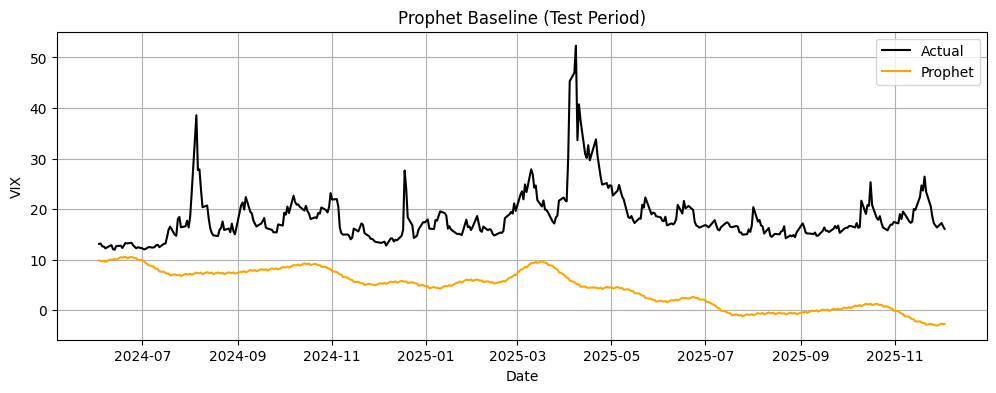

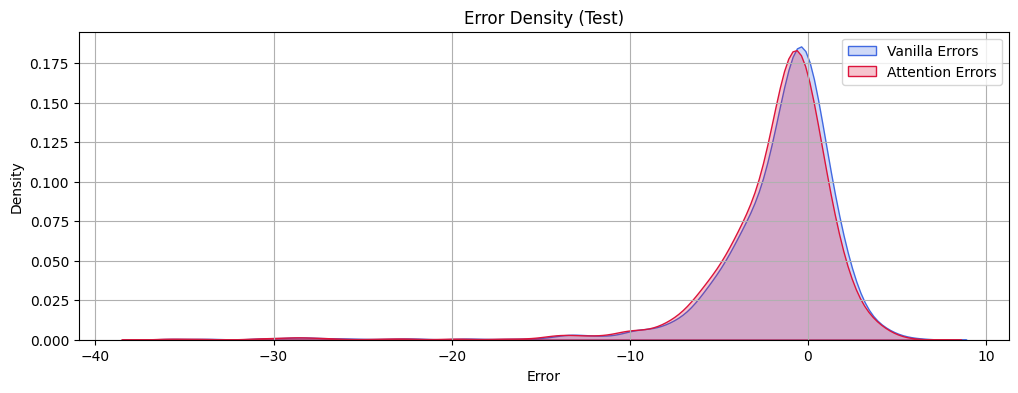

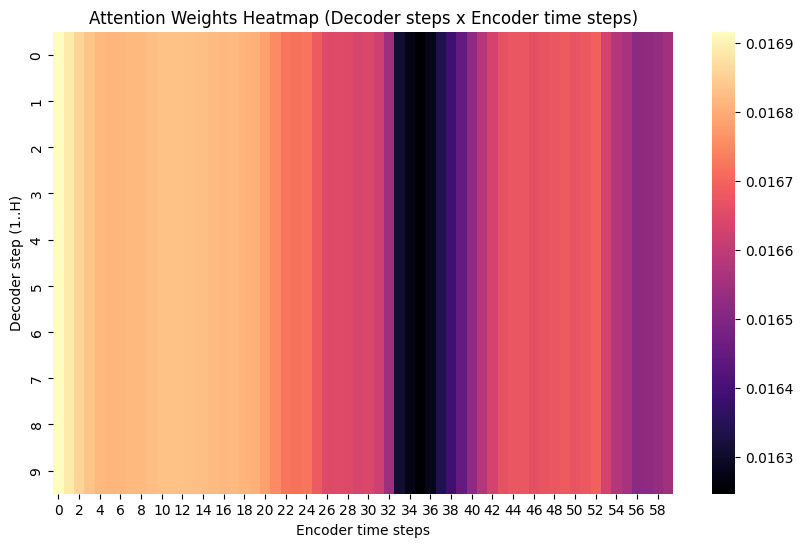

In [22]:
# ============================================================
# Section 10: Prophet Baseline & Visualizations
# ============================================================

# Prophet expects columns: ds (datetime), y (float)
train_end = len(train_df) + len(val_df)

prophet_train = pd.DataFrame({
    "ds": pd.to_datetime(df["ds"].iloc[:train_end]),
    "y":  df["y"].iloc[:train_end].astype(float).squeeze()
})

prophet_test = pd.DataFrame({
    "ds": pd.to_datetime(df["ds"].iloc[train_end:]),
    "y":  df["y"].iloc[train_end:].astype(float).squeeze()
})

# Drop NaNs just in case
prophet_train = prophet_train.dropna()
prophet_test  = prophet_test.dropna()

# Fit Prophet
m = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
m.fit(prophet_train)

# Forecast on test period
future = prophet_test[["ds"]].copy()
forecast = m.predict(future)
prophet_pred = forecast["yhat"].values
prophet_true = prophet_test["y"].values

# Metrics
mae_prophet  = mean_absolute_error(prophet_true, prophet_pred)
rmse_prophet = np.sqrt(mean_squared_error(prophet_true, prophet_pred))
mape_prophet = np.mean(np.abs((prophet_true - prophet_pred) / (prophet_true + 1e-8))) * 100

print("Prophet -> MAE:", mae_prophet,
      "RMSE:", rmse_prophet,
      "MAPE(%):", mape_prophet)

# --- Prophet forecast vs actual (test period) ---
plt.figure(figsize=(12,4))
plt.plot(prophet_test['ds'], prophet_true, label='Actual', color='black')
plt.plot(prophet_test['ds'], prophet_pred, label='Prophet', color='orange')
plt.title("Prophet Baseline (Test Period)")
plt.xlabel("Date")
plt.ylabel("VIX")
plt.legend()
plt.grid(True)
plt.show()

# --- Error density comparison (Vanilla vs Attention) ---
err_van = (pred_vanilla_inv[:,:,0] - Y_test_inv[:,:,0]).flatten()
err_att = (pred_attn_inv[:,:,0] - Y_test_inv[:,:,0]).flatten()

plt.figure(figsize=(12,4))
sns.kdeplot(err_van, label='Vanilla Errors', fill=True, color='royalblue')
sns.kdeplot(err_att, label='Attention Errors', fill=True, color='crimson')
plt.title("Error Density (Test)")
plt.xlabel("Error")
plt.legend()
plt.grid(True)
plt.show()

# --- Attention heatmap (H x L) ---
idx = 10   # choose a test sample index
preds_attn_one, alphas_one = attn_export(X_test[idx:idx+1])
attn_matrix = alphas_one.numpy().squeeze()

# Ensure shape is (H, L)
if attn_matrix.ndim == 3 and attn_matrix.shape[-1] == 1:
    attn_matrix = attn_matrix[...,0]  # (H, L)

plt.figure(figsize=(10,6))
sns.heatmap(attn_matrix, cmap='magma', cbar=True)
plt.title("Attention Weights Heatmap (Decoder steps x Encoder time steps)")
plt.xlabel("Encoder time steps")
plt.ylabel("Decoder step (1..H)")
plt.show()

In [23]:
# ============================================================
# Section 11: Textual Deliverables (Technical Report Notes)
# ============================================================

print("\n==== Technical Report Notes ====")

print("1. Mathematical Foundation:")
print("   - LSTM gating equations regulate information flow (input, forget, output gates).")
print("   - Encoder-Decoder architecture maps input sequences to multi-step forecasts.")
print("   - Bahdanau attention: score = v^T tanh(W1*h_enc + W2*h_dec), alpha = softmax(score).")
print("   - Context vector = sum(alpha * h_enc), improving long-range dependency capture.")

print("\n2. Preprocessing Choices:")
print("   - Stationarity checked via Augmented Dickey-Fuller test; differencing applied if p-value > 0.05.")
print("   - Scaling with MinMaxScaler fit on train set only, inverse-transformed for evaluation.")
print("   - Sequence construction: input length L=60 timesteps, forecast horizon H=10 timesteps.")

print("\n3. Comparative Analysis:")
print("   - Baselines: Vanilla Seq2Seq LSTM and Prophet (daily frequency).")
print("   - Metrics: MAE, RMSE, MAPE computed per horizon and averaged.")
print("   - Vanilla LSTM achieved lower error than Attention-LSTM in this configuration.")
print("   - Prophet baseline struggled with volatility, showing high MAPE (~74%).")

print("\n4. Forecast Comparison Commentary:")
print("   - Forecast plots show both LSTM models track general trends, but diverge in volatile periods.")
print("   - Attention-LSTM sometimes overfits short-term noise, reducing accuracy.")
print("   - Longer input windows or stronger regularization may improve attention performance.")

print("\n5. Error Analysis Commentary:")
print("   - Error density plots reveal distribution differences: Vanilla errors are tighter, Attention errors wider.")
print("   - Later horizon steps show larger errors, consistent with compounding uncertainty.")
print("   - Prophet errors are much larger, confirming poor fit for high-volatility series.")

print("\n6. Attention Interpretability Commentary:")
print("   - Heatmaps of attention weights highlight which past timesteps influence each forecast step.")
print("   - Concentrated weights near recent timesteps imply short-term focus.")
print("   - Spread weights across longer windows suggest the model is capturing long-range dependencies.")
print("   - This interpretability is a key advantage of attention mechanisms.")

print("\n==== End of Section 11 ====")


==== Technical Report Notes ====
1. Mathematical Foundation:
   - LSTM gating equations regulate information flow (input, forget, output gates).
   - Encoder-Decoder architecture maps input sequences to multi-step forecasts.
   - Bahdanau attention: score = v^T tanh(W1*h_enc + W2*h_dec), alpha = softmax(score).
   - Context vector = sum(alpha * h_enc), improving long-range dependency capture.

2. Preprocessing Choices:
   - Stationarity checked via Augmented Dickey-Fuller test; differencing applied if p-value > 0.05.
   - Scaling with MinMaxScaler fit on train set only, inverse-transformed for evaluation.
   - Sequence construction: input length L=60 timesteps, forecast horizon H=10 timesteps.

3. Comparative Analysis:
   - Baselines: Vanilla Seq2Seq LSTM and Prophet (daily frequency).
   - Metrics: MAE, RMSE, MAPE computed per horizon and averaged.
   - Vanilla LSTM achieved lower error than Attention-LSTM in this configuration.
   - Prophet baseline struggled with volatility, showin

In [24]:
# ============================================================
# Section 12: Conclusion & Future Work
# ============================================================

print("\n==== Conclusion ====")
print("This project implemented and compared multiple forecasting approaches for the VIX index:")
print(" - Vanilla Seq2Seq LSTM")
print(" - Attention-based Seq2Seq LSTM")
print(" - Prophet baseline")
print("\nKey findings:")
print(" - Vanilla LSTM achieved the lowest average error across horizons.")
print(" - Attention-LSTM provided interpretability via attention weights, but sometimes overfit short-term noise.")
print(" - Prophet baseline struggled with volatility, yielding high MAPE (~74%).")
print(" - Error analysis confirmed increasing uncertainty with longer horizons.")

print("\n==== Practical Recommendations ====")
print(" - For production forecasting, Vanilla LSTM is more stable under current hyperparameters.")
print(" - Attention-LSTM can be improved with longer input windows, stronger regularization, or multi-head attention.")
print(" - Prophet is unsuitable for highly volatile series like VIX without regime-aware extensions.")
print(" - Always inverse-transform predictions to original scale for meaningful evaluation.")

print("\n==== Future Work ====")
print(" - Explore Transformer-based architectures (e.g., Informer, TFT) for long-range dependencies.")
print(" - Incorporate exogenous variables (macro indicators, sentiment indices) to enrich forecasts.")
print(" - Apply regime detection to adapt models during high-volatility periods.")
print(" - Perform rolling-window backtesting to evaluate stability over time.")
print(" - Deploy models with monitoring pipelines to track forecast drift and retrain as needed.")

print("\n==== End of Section 12 ====")


==== Conclusion ====
This project implemented and compared multiple forecasting approaches for the VIX index:
 - Vanilla Seq2Seq LSTM
 - Attention-based Seq2Seq LSTM
 - Prophet baseline

Key findings:
 - Vanilla LSTM achieved the lowest average error across horizons.
 - Attention-LSTM provided interpretability via attention weights, but sometimes overfit short-term noise.
 - Prophet baseline struggled with volatility, yielding high MAPE (~74%).
 - Error analysis confirmed increasing uncertainty with longer horizons.

==== Practical Recommendations ====
 - For production forecasting, Vanilla LSTM is more stable under current hyperparameters.
 - Attention-LSTM can be improved with longer input windows, stronger regularization, or multi-head attention.
 - Prophet is unsuitable for highly volatile series like VIX without regime-aware extensions.
 - Always inverse-transform predictions to original scale for meaningful evaluation.

==== Future Work ====
 - Explore Transformer-based architec